[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxNaeg/ode_fitting_jax_tutorial/blob/main/exercise.ipynb)


In [16]:
import jax
import jax.numpy as jnp
from jax import vmap

import optax

import numpy as np
import matplotlib.pyplot as plt

# Tutorial mode
In this tutorial, you will go through the notebook below and fill in missing parts of the code (as indicated by 'TODO' statements). The notebook should be self-contained. The idea is that you start working independently at your own pace and ask for help/clarifications when you are stuck.
Please consider the following for an optimized learning experience:
1. You can work alone, in teams of two, or in small groups. Whatever works best for you.
2. If parts of the plain text explanations are unclear, don't waste time and ask for clarification. Depending on your background, you will need to learn many new concepts in both physics and programming, so it's expected that you'll need some help.
3. Try a few minutes per missing code snippet to get the cell running, but if you are stuck also ask for help.
4. Use Google and the JAX documentation to help. Consider switching off Copilot or at the very least try to understand its suggestions.

After an hour, I will push the solution to the GitHub repo. You can decide for yourself, whether you learn better by looking at it or by finishing the exercises by yourself.

# Automatic discovery of equations of motion

In this notebook, we will learn how to use JAX and gradient descent to fit the parameters of an ordinary differential equation (ODE) to data. First order ODEs are of the form:
$$ \mathbf{\dot X}(t) = \mathbf{f}(\mathbf{X}(t), \theta),$$
where $\mathbf{X}(t)$ is a vector describing the state of the system at time $t$, $ \mathbf{\dot X}(t) = \frac{d \mathbf{X}(t)}{dt}$, $\mathbf{f}$ is a function determining the velocity of $\mathbf{X}$ at each time step, and $\theta$ are some additional parameters of $\mathbf{f}$.

In the following we consider a one dimensional physical system. We can write Newton's law as a first order ODE (setting the mass to 1):
$$\ddot x = F(x, \theta) = -\frac{d V(x, \theta)}{dx}$$
$$\rightarrow \dot x = v, \dot v =-\frac{d V(x, \theta)}{dx}$$
$$\rightarrow \mathbf{X}(t) = [x, v], \mathbf{\dot X}(t) = \left[v, -\frac{d V(x, \theta)}{dx}\right]=\mathbf{f}(\mathbf{X}(t), \theta)$$

This trick of transfroming an n-dimensional second order ODE into a 2n-dimensional first order ODE is quite common for both numerical and analytical analysis of ODEs.

The structure of this notebook is as follows:
1. Analyze a dataset containing some trajectories of an unknown  ODE. Guess an ansatz for $V(x, \theta)$.
2. Write code to numerically solve an ODE given $\mathbf{f}(\mathbf{X}(t), \theta)$.
3. Use gradient descent to automatically optimize $\theta$ to fit the observed data.

If you are exceptionally fast, you can consider tackling the two bonus exercises:
1. Replacing your ansatz for $V(x, \theta)$ by a neural network.
2. Dealing with partial observability of $\mathbf{X}(t)$.

# Analyze the dataset

In [17]:
# Run this cell to command the data in case you haven't cloned the repository but are running in colab instead.
# If you have cloned the repository, you can skip this cell.
!wget https://github.com/MaxNaeg/ode_fitting_jax_tutorial/raw/main/mystery_trajectories.npz -O mystery_trajectories.npz

--2025-06-01 09:38:12--  https://github.com/MaxNaeg/ode_fitting_jax_tutorial/raw/main/mystery_trajectories.npz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxNaeg/ode_fitting_jax_tutorial/main/mystery_trajectories.npz [following]
--2025-06-01 09:38:12--  https://raw.githubusercontent.com/MaxNaeg/ode_fitting_jax_tutorial/main/mystery_trajectories.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 803672 (785K) [application/octet-stream]
Saving to: ‘mystery_trajectories.npz’

mystery_trajectorie 100%[===================>] 784.84K  --.-KB/s    in 0.06s   

2025-06-01 09:38:12 (13.5 MB/s) - ‘my

Imagine you gathered a dataset (maybe from an experiment) containing multiple trajectories of a particle with different initial conditions. You know that your particle is moving under Newton's law in an unknown potential. We are dealing with a one dimensional system and you recorded  the position and velocity of the particle at each time step. The data is saved in Xs_obs of shape (num_initial_conditions, num_timesteps, 2). The first index of Xs_obs specifies the trajectory, the second index the time step, and the last index is 0 for the position and 1 for the velocity of the particle.

In [18]:
# Load the dataset
data = np.load('mystery_trajectories.npz')
Xs_obs = data['Xs_obs']  # Measured data as a function of time, shape (num_initial_conditions, num_timesteps, 2)
positions_true = Xs_obs[:, :, 0]  # Extract position data x, shape (num_initial_conditions, num_timesteps)
initial_conditions = data['initial_conditions']  # Initial conditions for each trajectory, shape (num_initial_conditions, 2)
dts = data['dts'] # Time step size for each trajectory, shape (num_initial_conditions,)
t_finals = data['t_finals'] # Final time for each trajectory, shape (num_initial_conditions,)
print(positions_true.shape, initial_conditions.shape, dts.shape, t_finals.shape)

(100, 1000) (100, 2) (100,) (100,)


In [19]:
print(initial_conditions[0,:])
print(dts[0])
print(t_finals[50])
print(np.unique(t_finals))
print(np.unique(dts))

[0.90048647 0.48634982]
0.01
10.0
[10.]
[0.01]


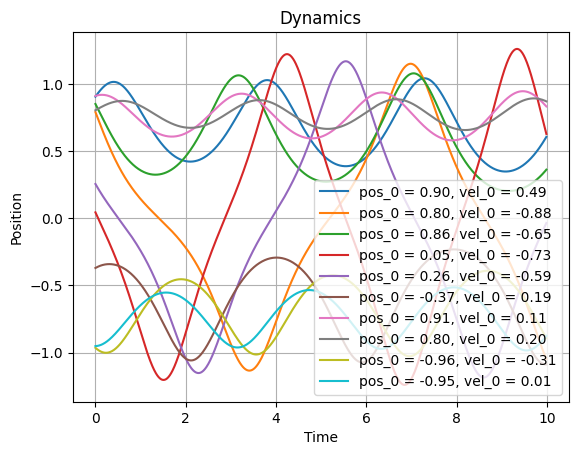

In [20]:
# Plot some of the trajectories
max_plot = 10  # Limit the number of plots to avoid clutter
time_axis = jnp.arange(0, t_finals[0], dts[0]) # Assuming all trajectories have the same time step and final time
for i in range(min(len(positions_true), max_plot)):
    plt.plot(time_axis, positions_true[i], label=f'pos_0 = {initial_conditions[i, 0]:.2f}, vel_0 = {initial_conditions[i, 1]:.2f}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Dynamics')
plt.legend()
plt.grid()
plt.show()

Spend a minute or two to guess the shape of the potential that produced these trajectories before scrolling to the solution below.
# STOP SCROLLING

Given the trajectories above, we observe oscillations around two different minima with some trajectories crossing from one to the other minimum. This look like a double well potential of the form
$$V(x, t, a, b) = a x^4 - b x^2$$
(a and b can be understood as components of $\theta$ above).
Complete the following jax function that computes the potential:

In [21]:
def potential_double_well(x, thetas):
    """Computes the potential energy of a double well potential as defined above.
    Args:
        x: Position (scalar or array)
        thetas: Parameters of the potential (a, b)
    Returns:
        Potential energy (scalar or array)
    """
    a, b = thetas
    #TODO: Implement the double well potential
    potential = a*x**4 - b*x**2
    return potential

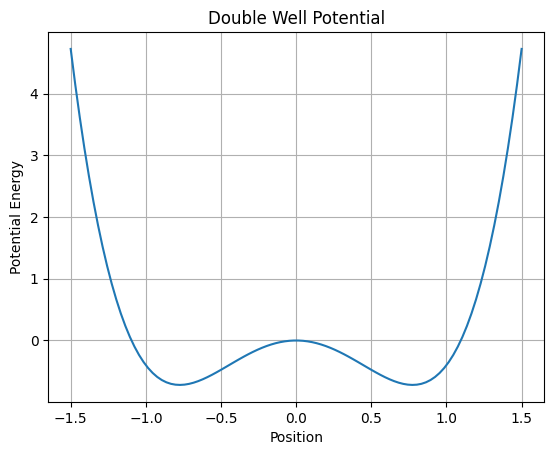

In [22]:
# Plot an example potential
x_values = jnp.linspace(-1.5, 1.5, 100)
a, b = 2.0, 2.4
y_values = potential_double_well(x_values, (a, b))
plt.plot(x_values, y_values)
plt.title("Double Well Potential")
plt.xlabel("Position")
plt.ylabel("Potential Energy")
plt.grid()

To solve the ODE given by the potential we need to be able to compute its right hand side, i.e. $\mathbf{f}(\mathbf{X}(t), \theta) = \mathbf{f}([x(t), v(t)], \theta) = \left[v, -\frac{d V(x, \theta)}{dx}\right]$.

In [23]:
# TODO: Get derivative of the potential with respect to x using jax.grad. potenital_derivative will be a function of type
# potential_derivative(x, thetas) -> dV/dx
potential_derivative = jax.grad(potential_double_well)

In [24]:
## testing the type of output for grad func
print(potential_double_well(1, (a, b)))
print(type(potential_double_well(1, (a, b))))

# input to grad func must be float or complex (inexact type)
print(potential_derivative(float(1), (a,b)))
print(type(potential_derivative(float(1), (a,b))))
print(x_values.shape)

-0.3999999999999999
<class 'float'>
3.1999998
<class 'jaxlib.xla_extension.ArrayImpl'>
(100,)


shape of force_values:  (100,)


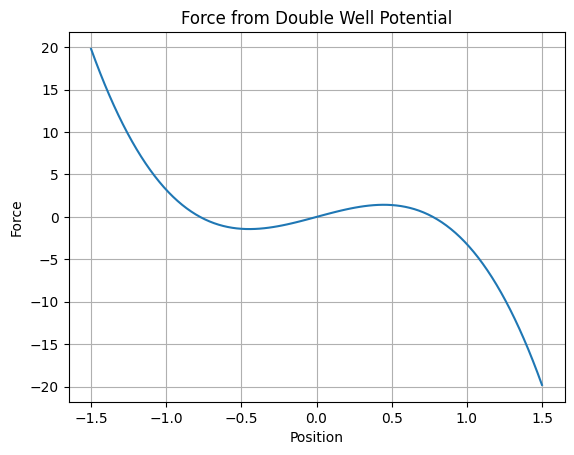

In [25]:
# Plot force for example parameters
# Use vmap to vectorize the computation of the right-hand side of potential_derivative
potential_derivative_vmap = vmap(potential_derivative, in_axes=(0, None), out_axes=0)
force_values = -potential_derivative_vmap(x_values, (a, b)) # -dV/dx at different x values
print("shape of force_values: ", np.shape(force_values))
plt.plot(x_values, force_values)
plt.title("Force from Double Well Potential")
plt.xlabel("Position")
plt.ylabel("Force")
plt.grid()

In [26]:
## 5/30/25 testing jax.vmap
dummy_func = lambda x: x**2

dummy_func_vmap = vmap(dummy_func, in_axes = 0, out_axes = 0)
x_vals = np.linspace(1, 10, 10)
print("xvals: ", x_vals)
x_vals_sq = dummy_func_vmap(x_vals)
print("x vals sq: ", x_vals_sq)

# testing 2D array input to dummy_func_vmap
xy_vals_2D = np.array([[1, 2], [3, 4], [5, 6], [7,8], [9,10]])
print("input 2D array: ", xy_vals_2D)
print("shape array_5D: ", np.shape(array_5D))
test_2D_out = dummy_func_vmap(xy_vals_2D)
print("test 2D out: ", test_2D_out)

dummy_func2 = lambda x, y: x**2 + y
dummy_func_vmap2 = vmap(dummy_func2, in_axes = (0,None), out_axes = 0)
x_vals2 = np.array([[1, 2], [3, 4], [5, 6], [7,8], [9,10]])
y_val = 2;
print("xvals2: ", x_vals2)
print("shape xvals2: ", np.shape(x_vals2))

x_vals2_sq = dummy_func_vmap2(x_vals2, y_val)
print("x vals2 sq: ", x_vals2_sq)

xvals:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
x vals sq:  [  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]
input 2D array:  [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]
shape array_5D:  (3, 3, 3, 4, 5)
test 2D out:  [[  1   4]
 [  9  16]
 [ 25  36]
 [ 49  64]
 [ 81 100]]
xvals2:  [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]
shape xvals2:  (5, 2)
x vals2 sq:  [[  3   6]
 [ 11  18]
 [ 27  38]
 [ 51  66]
 [ 83 102]]


In [27]:
print(potential_derivative_vmap.shape)

AttributeError: 'function' object has no attribute 'shape'

# Solving ODEs in JAX
In the following we write code to solve an ODE from scratch since you can learn a lot about JAX doing it. For real applications, you would probably use libraries providing more advanced ODE solvers (higher order methods, adaptive step size) such as diffrax (https://docs.kidger.site/diffrax/).

In [28]:
# Now we can define the right-hand side of the ODE for the double well potential, i.e. the function f above.
def rhs_double_well(X:jax.Array, thetas:jax.Array) -> jax.Array:
    """
    Right-hand side of the double well potential ODE.

    Args:
        X: Current value of the state variable (position and velocity)
        thetas: Parameters for the ODE. Tuple of (a, b) where:
            - a: Coefficient for the quartic term
            - b: Coefficient for the quadratic term
    Returns:
        The derivative of X at the current time, given the parameters.
    """
    x, v = X
    # Compute the force as the negative gradient of the potential
    force = -potential_derivative(x, thetas)
    # Return the derivatives: velocity and force
    return jnp.array([v, force])

We can solve ODEs numerically by discretizing time on a small enough grid. Then
$$\mathbf{X}(t_{j+1}) \approx \mathbf{X}(t_j) + \delta t * \mathbf{f}(\mathbf{X}(t_j), \theta),$$
where $\delta t$ is a small time step (dt in the code).
For solving the ODE we calculate:
```
input: X0, rhs, thetas
ts = arange(0, t_final, dt)
X = X0
Xs = [X,]
for step in ts:
    X = X + dt * rhs(X, thetas)
    Xs.append(X)
return Xs
```
As you know, it is best to avoid for-loops in JAX (they can either not be jitted or at the very least require long compile times). Therefore, we will use the jax.lax.scan function instead. Check out the docs at https://docs.jax.dev/en/latest/_autosummary/jax.lax.scan.html !

In [32]:
def ode_solve(X0:jax.Array, rhs:callable, dt:float, t_final:float, thetas:jax.Array) -> tuple:
    """
    Solve the differential equation dX/dt=rhs(X,thetas) for equally spaced times with initial value X(t=0)=X0.

   Args:
    X0: Initial conddition
    rhs: Function that computes the right-hand side of the ODE, called like rhs(X,thetas)
    dt: Time step size
    t_final: Final time to which the ODE should be solved
    thetas: Parameters for the rhs function
    Returns:
        A tuple (Xs,ts) where:
            Xs: The solution at all time steps, with shape (nsteps, *X0.shape)
            ts: The time steps, a 1d array of shape (nsteps,)
    """


    def single_step(X:jax.Array, t:float):
        # Calculate new X one step forward in time
        # TODO: Implement the single step of the ODE solver
        X = X+dt*rhs(X, thetas)
        return X, X

    ts=jnp.arange(0., t_final, dt)
    finalX, Xs = jax.lax.scan(single_step, init=X0, xs=ts)
    print("finalX: ", finalX);
    print("last element in Xs: ", Xs[-1])

    return Xs, ts

In [30]:
np.shape(initial_conditions)


(100, 2)

finalX:  [0.81572527 1.1738919 ]
last element in Xs:  [0.81572527 1.1738919 ]
shape of Xs:  (1000, 2)


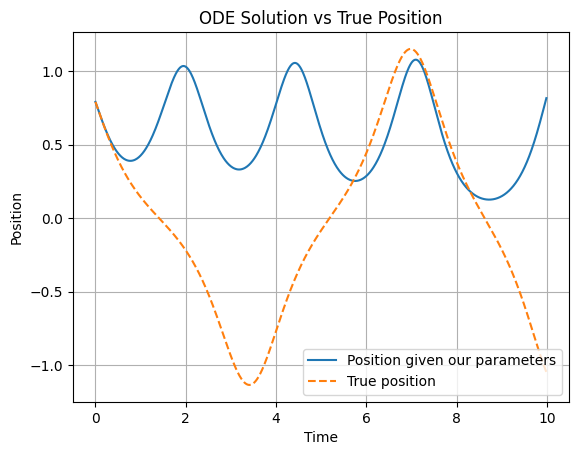

In [34]:
# Solve the ODE for a single initial condition
solution_idx = 1
X0 = jnp.array(initial_conditions[solution_idx])
a = 2.0  # Coefficient for the quartic term
b = 2.4  # Coefficient for the quadratic term
thetas = jnp.array([a, b])
dt = dts[solution_idx]
t_final = t_finals[solution_idx]
Xs, ts = ode_solve(X0, rhs_double_well, dt, t_final, thetas)
print("shape of Xs: ", Xs.shape)
# Plot the solution
plt.plot(ts, Xs[:, 0], label='Position given our parameters')
plt.plot(ts, positions_true[solution_idx], label='True position', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('ODE Solution vs True Position')
plt.legend()
plt.grid()

We can see that our parameters are not completely correct yet. Let's optimize them using gradient descent. Our goal is to minimize the mean square error between the observed right-hand side of the ODE and the right-hand side predicted by our parameters. Our loss function is
$$L = \sum_i \sum_j \left(\mathbf{f}^{(observed)}\left(\mathbf{X_i}(t_j)\right) - \mathbf{f}^{(predicted)}\left(\mathbf{X_i}(t_j), \theta\right)\right),$$
where we can estimate
$$\mathbf{f}^{(observed)}\left(\mathbf{X_i}(t_j)\right) \approx \frac{\mathbf{X_i}(t_{j+1}) - \mathbf{X_i}(t_j)}{\delta t},$$
and $\mathbf{f}^{(predicted)}\left(\mathbf{X_i}(t_j), \theta\right)$ can be calculated using our ansatz function (rhs_func in the code).
Here, $\delta t$ is the time step size (dt in the code), the index $i$ runs over all observed trajectories, and the index $j$ over all discretized timesteps.

In [38]:
optimizer = optax.adam(learning_rate=0.01) # Initialize the optimizer
dt = dts[0]  # Assuming all dts are the same for simplicity

def train_step(thetas, opt_state, Xs_obs, rhs_func):
    """
    Perform a single training step to update the parameters.
    Minimizes the mean squared error between the predicted and observed right-hand side of the ODE.

    Args:
        thetas: Current parameters for the ODE
        opt_state: Current state of the optimizer
        Xs_obs: Observed trajectories from the dataset, shape (num_initial_conditions, num_timesteps, ode dimension)
        rhs_func: Function that computes the right-hand side of the ODE, called like rhs_func(X, thetas)
    Returns:
        Updated parameters and optimizer state.
    """
    ode_dim = Xs_obs.shape[-1]  # Dimension of the ODE state (e.g., position and velocity)
    def loss_fn(thetas):
        '''Compute the mean squared error between the predicted and observed right-hand side of the ODE.'''
        # TODO: Vectorize the rhs function to handle inputs at axis 0 of shape (number_inputs, ode_dim)
        rhs_func_vmapped = vmap(rhs_func, in_axes=(0,None), out_axes=0); # current rhs_func maps X, thetas --> jnp.array([v, force])
        # Flatten the first two dimensions of Xs_obs to make it compatible with vmapped rhs function
        Xs_obs_flat = Xs_obs[:, :-1, :].reshape(-1, ode_dim)
        # Compute the right-hand side for all oberved trajectories and timesteps
        predicted_rhs_flat = rhs_func_vmapped(Xs_obs_flat, thetas)
        print("shape of input Xs_obs: ", Xs_obs.shape)
        print("shape predicted_rhs_flat: ", predicted_rhs_flat.shape) # should be num_init_cond*num_tsteps, 2 (gives a [v, force] for each batch index)

        # TODO: compute observed rhs for each trajectory and timestep
        rhs_obs = (Xs_obs[:,1:,:] - Xs_obs[:,:-1,:])/dt
        print("shape rhs_obs: ", rhs_obs.shape)
        # flatten the observed rhs to match the shape of predicted_rhs
        rhs_obs_flat = rhs_obs.reshape(-1, ode_dim)

        # Compute the mean squared error between predicted and observed rhs
        mse = jnp.mean((predicted_rhs_flat - rhs_obs_flat) ** 2)

        return mse

    # Compute the loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(thetas)
    # Update the parameters using the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    thetas = optax.apply_updates(thetas, updates)
    return thetas, opt_state, loss

In [35]:
Xs_obs.shape # shape = (num_initial_conditions, num_timesteps, 2); first index is trajectory index

(100, 1000, 2)

In [39]:
# Test the training step function
init_thetas = jnp.array([2.0, 2.4])  # Initial guess for the parameters
opt_state = optimizer.init(init_thetas) # Initial state of the optimizer

train_step(init_thetas, opt_state, Xs_obs, rhs_double_well)

shape of input Xs_obs:  (100, 1000, 2)
shape predicted_rhs_flat:  (99900, 2)
shape rhs_obs:  (100, 999, 2)


(Array([1.99, 2.41], dtype=float32),
 (ScaleByAdamState(count=Array(1, dtype=int32), mu=Array([ 0.2546335, -0.0907722], dtype=float32), nu=Array([0.00648382, 0.00082396], dtype=float32)),
  EmptyState()),
 Array(0.8104648, dtype=float32))

In [40]:
# Build the training loop
num_train_steps = 1000  # Number of training steps


def train(num_train_steps, thetas, opt_state, Xs_obs, rhs_func):
# train loop using lax scan
    def single_step(carry, _): # none in 2nd arg bc don't need to save state at each point (unlike in time evolution case)
        thetas, opt_state = carry
        # TODO: Perform a single training step
        thetas, opt_state, loss = train_step(thetas, opt_state, Xs_obs, rhs_double_well)
        return (thetas, opt_state), loss # saves loss at each step in num_train_steps
    (final_thetas, final_opt_state), losses = jax.lax.scan(single_step, init=(thetas, opt_state), xs=None, length=num_train_steps)
    return final_thetas, final_opt_state, losses

final_thetas, final_opt_state, losses = train(num_train_steps, init_thetas, opt_state, Xs_obs, rhs_double_well)
print(f'Inital parameters: {init_thetas}')
print(f'Final parameters: {final_thetas}')
print("shape of losses: ", losses.shape)

shape of input Xs_obs:  (100, 1000, 2)
shape predicted_rhs_flat:  (99900, 2)
shape rhs_obs:  (100, 999, 2)
Inital parameters: [2.  2.4]
Final parameters: [0.900001  1.1000018]
shape of losses:  (1000,)


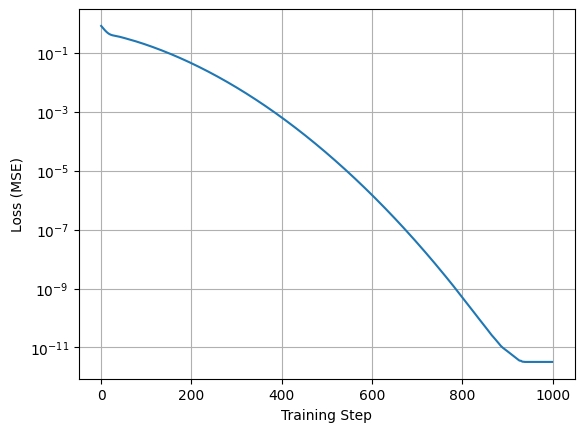

In [41]:
plt.plot(losses)
plt.grid()
plt.xlabel('Training Step')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

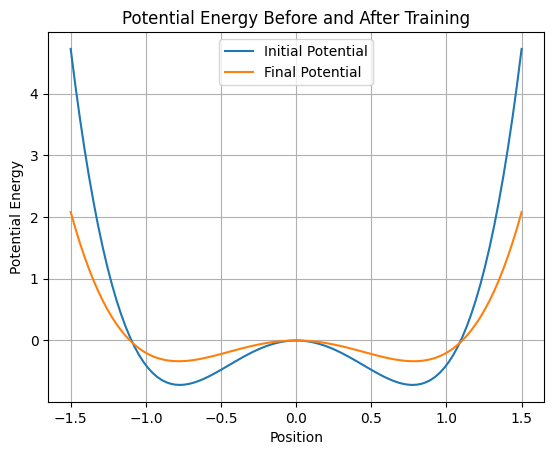

In [42]:
# plot inital and final potential
x_values = jnp.linspace(-1.5, 1.5, 100)
y_values_initial = potential_double_well(x_values, init_thetas)
y_values_final = potential_double_well(x_values, final_thetas)
plt.plot(x_values, y_values_initial, label='Initial Potential')
plt.plot(x_values, y_values_final, label='Final Potential')
plt.title("Potential Energy Before and After Training")
plt.xlabel("Position")
plt.ylabel("Potential Energy")
plt.legend()
plt.grid()

finalX:  [-1.0471929 -0.7487584]
last element in Xs:  [-1.0471929 -0.7487584]
finalX:  [0.81572527 1.1738919 ]
last element in Xs:  [0.81572527 1.1738919 ]


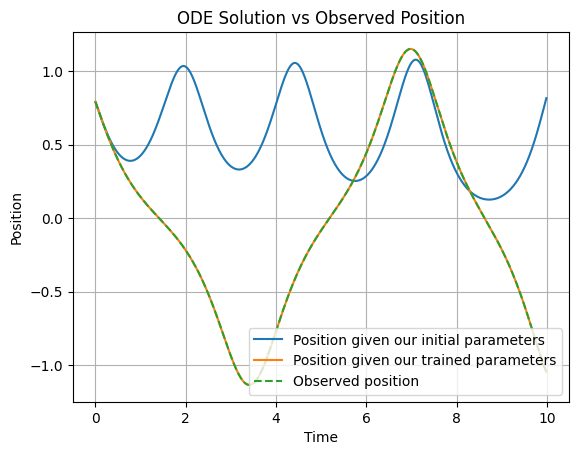

In [43]:
# Solve the ODE for a single initial condition
X0 = jnp.array(initial_conditions[solution_idx])
t_final = t_finals[solution_idx]
Xs_final, ts = ode_solve(X0, rhs_double_well, dt, t_final, final_thetas)
Xs_init, ts_init = ode_solve(X0, rhs_double_well, dt, t_final, init_thetas)
# Plot the solution
plt.plot(ts_init, Xs_init[:, 0], label='Position given our initial parameters')
plt.plot(ts, Xs_final[:, 0], label='Position given our trained parameters')
plt.plot(ts, positions_true[solution_idx], label='Observed position', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('ODE Solution vs Observed Position')
plt.legend()
plt.grid()

# Congratulations
You successfully finished this tutorial. You now understand how to use the functions jax.lax.scan, vmap, and grad. You can combine them to write a simple training loop using an optax optimizer. Finally, you applied your knowledge to solve a fundamental problem in physics: Finding governing equations given some observed data.

# Outlook

This was the simplest case of fitting an ODE: Equally spaced time-points on a dense grid and obervability of the full state of the system (in our case, position and velocity). There are also more complicated cases:
1. Your trajectory is not sampled on a dense grid, so you cannot estimate the derivatives of your state vector from the observed data -> Your loss function could now be the MSE between the trajectory your parameters predict for the given initial condition with the observed trajectory. You now need to backpropagate through your whole ODE solver, which might lead to memory problems. An elegant solution to this is using the adjoint trick from the neural ODEs paper: https://arxiv.org/abs/1806.07366.
2. Only a known (non-invertible) function $\mathbf{g}(\mathbf{X}(t))$ is observed but the initial condition is fully known -> Similar as above, but use MSE between observed and predicted value of $\mathbf{g}$.
3. Only a known (non-invertible) function $\mathbf{g}(\mathbf{X}(t))$ is observed and the initial condition is also not fully known -> Similar as above, but also treat the unknown part of the initial condition as a trainable parameter

# Bonus exercise 1
In a more complicated setting you might not know a good ansatz for the potential. In that case, you might consider replacing it with a neural network. Can you write code doing this? You may use the neural network code from the lecture, or the simpler but less general code in the cell below. You should only need to replace the rhs function. The training loop can stay the same. A NN with one hidden layer of size 8 should be enough for this problem.

In [ ]:
# Some code to create a simple one-hidden-layer neural network with one input and one output.
def onedimensional_one_hidden_layer_NN(x, thetas): # this basically replaces the 'potential_double_well(x, thetas)' function from above; thetas are now NN weights rather than coeffs now
    """
    A simple one-dimensional, one-hidden-layer neural network.
    Args:
        x: float
        thetas: Parameters of the neural network, a tuple of (W1, b1, W2, b2) where:
            - W1: Weights for the hidden layer, shape (hidden_dim, 1)
            - b1: Bias for the hidden layer, shape (hidden_dim,)
            - W2: Weights for the output layer, shape (1, hidden_dim)
            - b2: Bias for the output layer, shape (1,)
    Returns:
        Output of the neural network: float
    """
    W1, b1, W2, b2 = thetas
    hidden_layer = jnp.tanh(jnp.matmul(W1, jnp.array([x,])) + b1) # Hidden layer with tanh activation
    output = jnp.matmul(W2, hidden_layer) + b2  # Output layer
    return jnp.squeeze(output)

# Initialize the parameters of the neural network
hidden_dim = 8
seed = 0
key0, key1 = jax.random.split(jax.random.PRNGKey(seed), 2)
nn_init_thetas = (
    jax.random.normal(jax.random.PRNGKey(0), (hidden_dim, 1)) * jnp.sqrt(2 / (hidden_dim + 1)),  # W1
    jnp.zeros(hidden_dim),  # b1
    jax.random.normal(jax.random.PRNGKey(2), (1, hidden_dim)) * jnp.sqrt(2 / (hidden_dim + 1)),  # W2
    jnp.zeros(1),  # b2
)

# Test the neural network with a single input
output_single = onedimensional_one_hidden_layer_NN(1. , nn_init_thetas)
print(f'Output for single input: {output_single}')

#Vectorize the neural network to handle multiple inputs
vmap_nn = jax.vmap(onedimensional_one_hidden_layer_NN, in_axes=(0, None), out_axes=0)
# Test the vectorized neural network with multiple inputs
x_test = jnp.array([1.0, 2.0, 3.0])
y_test = vmap_nn(x_test, nn_init_thetas)
print(f'Output for multiple inputs: {y_test}')

Output for single input: -0.9616158604621887
Output for multiple inputs: [-0.96161586 -1.3629367  -1.4515712 ]


You may follow the steps below to solve the bonus exercise:
1. Interpret onedimensional_one_hidden_layer_NN(x, thetas) as your potential ansatz. Get it's gradient wrt x using jax.grad. Let's call this function force_nn(x, thetas).
2. Define a new rhs function, where you use the force_nn function to compute the force.
3. Initialize your optimizer parameters with the parameters of the NN.
4. You can now use the train function similar as above, simply replacing the input arguments.

# Bonus exercise 2
Imagine we can only observe the position (not velocity) of our trajectories at every 50th time point. We are now in scenario two described in the outlook. This means we cannot estimate $\mathbf{f}^{(observed)}\left(\mathbf{X_i}(t_j)\right)$ from our observed data. Can you write code that can still find the true a and b values?

In the loss function, you need to solve the ODE given your ansatz for the rhs function for each observed initial condition. You can then compute the MSE between the predicted and observed positions as your loss.


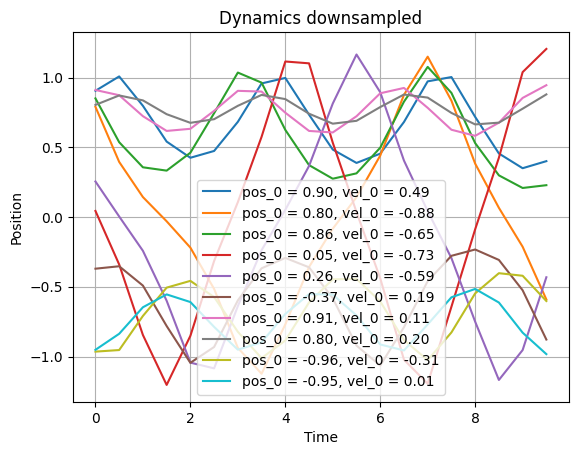

In [ ]:
# Dataset with every 50th point
sample_every = 50
pos_obs_downsampled = Xs_obs[:, ::sample_every, 0]  # Downsample every 10th point
# Plot some of the trajectories
max_plot = 10  # Limit the number of plots to avoid clutter
time_axis = jnp.arange(0, t_finals[0], dts[0])[::sample_every] # assuming all trajectories have the same time step and final time
for i in range(min(len(positions_true), max_plot)):
    plt.plot(time_axis, pos_obs_downsampled[i], label=f'pos_0 = {initial_conditions[i, 0]:.2f}, vel_0 = {initial_conditions[i, 1]:.2f}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Dynamics downsampled')
plt.legend()
plt.grid()
plt.show()